In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=5843dc2bf178034c380e13ceb97f10e73e571e81ec19a67fc610ab781cb2e935
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-01-17 15:12:56--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-17 15:12:57--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>] 

In [2]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-01-17 15:23:43--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  16.3MB/s    in 48s     

2025-01-17 15:24:32 (16.0 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [55]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [56]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x


In [57]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [58]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [59]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [60]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [61]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x


In [62]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [63]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [64]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [65]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [66]:
model = LevitDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [67]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [68]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms

# 데이터셋 경로
dataset_dir = './train/NCT-CRC-HE-100K'

# 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 로드
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# 데이터셋 길이
total_size = len(full_dataset)
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.15)
test_size = total_size - train_size - val_size  # 나머지를 테스트셋에 할당

# 데이터셋 나누기
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])

In [69]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


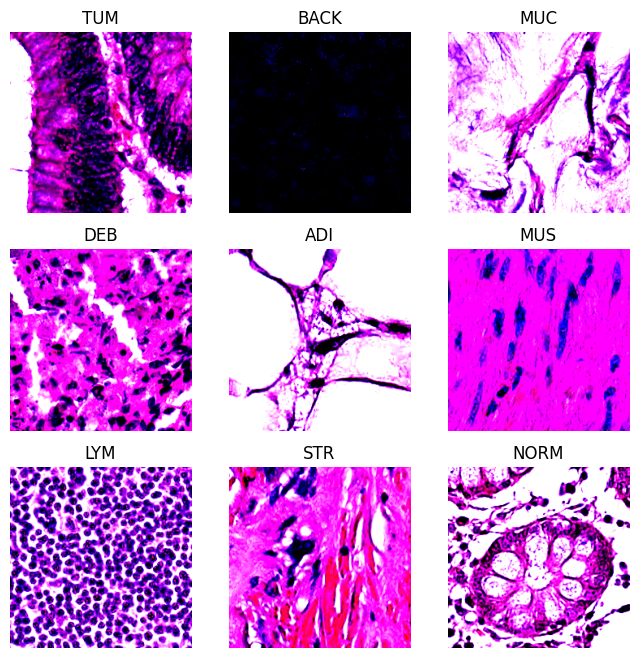

In [70]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(train_set.dataset.classes):
            break
    if len(class_examples) == len(train_set.dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(train_set.dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(train_set.dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [72]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [73]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [74]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [75]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [76]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.90it/s]


Train Loss: 0.5127, Train Accuracy: 81.87%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Validation Loss: 0.3646, Validation Accuracy: 87.84%

Epoch 2/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.96it/s]


Train Loss: 0.2330, Train Accuracy: 92.21%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]


Validation Loss: 0.2815, Validation Accuracy: 90.73%

Epoch 3/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.98it/s]


Train Loss: 0.1700, Train Accuracy: 94.30%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Validation Loss: 0.1368, Validation Accuracy: 95.49%

Epoch 4/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.95it/s]


Train Loss: 0.1326, Train Accuracy: 95.57%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]


Validation Loss: 0.1820, Validation Accuracy: 93.45%

Epoch 5/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.96it/s]


Train Loss: 0.1083, Train Accuracy: 96.31%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]


Validation Loss: 0.1272, Validation Accuracy: 95.77%

Epoch 6/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.98it/s]


Train Loss: 0.0937, Train Accuracy: 96.99%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]


Validation Loss: 0.0993, Validation Accuracy: 96.53%

Epoch 7/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.95it/s]


Train Loss: 0.0766, Train Accuracy: 97.48%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Validation Loss: 0.1965, Validation Accuracy: 93.62%

Epoch 8/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.93it/s]


Train Loss: 0.0664, Train Accuracy: 97.84%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]


Validation Loss: 0.0649, Validation Accuracy: 97.88%

Epoch 9/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.97it/s]


Train Loss: 0.0588, Train Accuracy: 98.06%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Validation Loss: 0.0426, Validation Accuracy: 98.64%

Epoch 10/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.99it/s]


Train Loss: 0.0517, Train Accuracy: 98.28%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]


Validation Loss: 0.0932, Validation Accuracy: 97.13%

Epoch 11/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.95it/s]


Train Loss: 0.0445, Train Accuracy: 98.51%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Validation Loss: 0.0512, Validation Accuracy: 98.37%

Epoch 12/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.96it/s]


Train Loss: 0.0414, Train Accuracy: 98.58%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Validation Loss: 0.0613, Validation Accuracy: 98.16%

Epoch 13/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.96it/s]


Train Loss: 0.0367, Train Accuracy: 98.78%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]


Validation Loss: 0.0591, Validation Accuracy: 97.80%

Epoch 14/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.90it/s]


Train Loss: 0.0326, Train Accuracy: 98.91%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


Validation Loss: 0.0980, Validation Accuracy: 96.98%

Epoch 15/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.97it/s]


Train Loss: 0.0332, Train Accuracy: 98.87%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Validation Loss: 0.0363, Validation Accuracy: 98.94%

Epoch 16/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.98it/s]


Train Loss: 0.0277, Train Accuracy: 99.08%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Validation Loss: 0.0627, Validation Accuracy: 98.14%

Epoch 17/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.94it/s]


Train Loss: 0.0261, Train Accuracy: 99.11%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Validation Loss: 0.0391, Validation Accuracy: 98.75%

Epoch 18/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.96it/s]


Train Loss: 0.0246, Train Accuracy: 99.19%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]


Validation Loss: 0.0418, Validation Accuracy: 98.69%

Epoch 19/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 13.00it/s]


Train Loss: 0.0249, Train Accuracy: 99.16%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Validation Loss: 0.0601, Validation Accuracy: 98.07%

Epoch 20/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.99it/s]


Train Loss: 0.0222, Train Accuracy: 99.27%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Validation Loss: 0.0389, Validation Accuracy: 98.90%

Epoch 21/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.98it/s]


Train Loss: 0.0212, Train Accuracy: 99.27%


Validation: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]


Validation Loss: 0.0530, Validation Accuracy: 98.43%

Epoch 22/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.97it/s]


Train Loss: 0.0197, Train Accuracy: 99.35%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


Validation Loss: 0.0343, Validation Accuracy: 99.09%

Epoch 23/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.95it/s]


Train Loss: 0.0183, Train Accuracy: 99.38%


Validation: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]


Validation Loss: 0.0745, Validation Accuracy: 98.06%

Epoch 24/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.94it/s]


Train Loss: 0.0177, Train Accuracy: 99.41%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]


Validation Loss: 0.0688, Validation Accuracy: 98.09%

Epoch 25/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.96it/s]


Train Loss: 0.0175, Train Accuracy: 99.41%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]


Validation Loss: 0.0656, Validation Accuracy: 98.11%

Epoch 26/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.97it/s]


Train Loss: 0.0176, Train Accuracy: 99.42%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Validation Loss: 0.0454, Validation Accuracy: 98.83%

Epoch 27/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.96it/s]


Train Loss: 0.0156, Train Accuracy: 99.50%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]


Validation Loss: 0.0416, Validation Accuracy: 99.01%

Epoch 28/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.95it/s]


Train Loss: 0.0152, Train Accuracy: 99.48%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Validation Loss: 0.0831, Validation Accuracy: 97.73%

Epoch 29/30


Training: 100%|██████████| 2188/2188 [02:49<00:00, 12.88it/s]


Train Loss: 0.0156, Train Accuracy: 99.47%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Validation Loss: 0.0454, Validation Accuracy: 98.79%

Epoch 30/30


Training: 100%|██████████| 2188/2188 [02:48<00:00, 12.98it/s]


Train Loss: 0.0143, Train Accuracy: 99.52%


Validation: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]

Validation Loss: 0.0474, Validation Accuracy: 98.79%


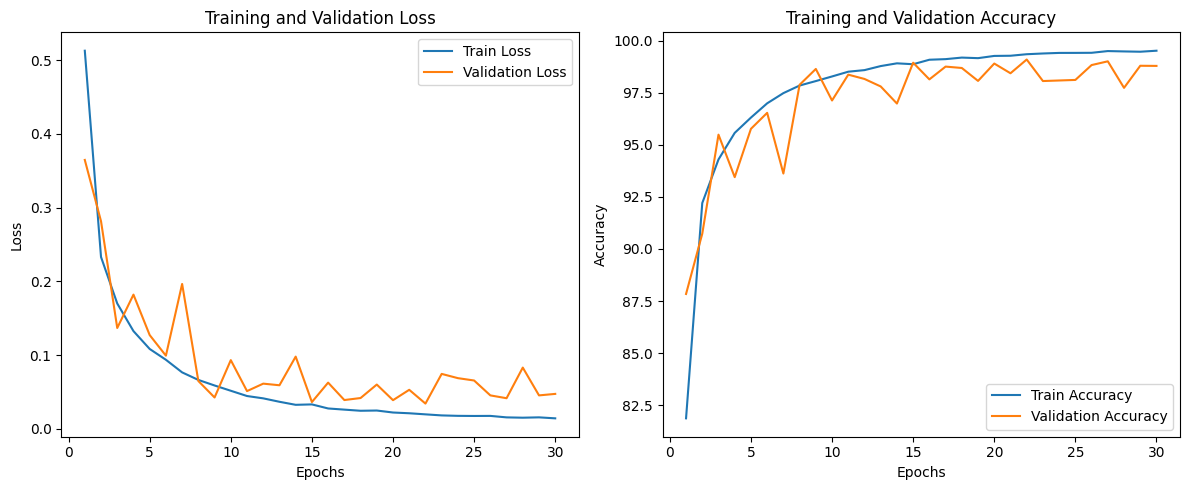

In [77]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 9.42 ms
Standard Deviation: 0.78 ms
Maximum Time: 12.86 ms
Minimum Time: 8.69 ms


In [79]:
evaluate(model, test_loader, criterion, device)

Validation: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]

Validation Loss: 0.0457, Validation Accuracy: 98.79%


In [80]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.29%     257.796us        25.27%       2.842ms      78.944us       0.000us         0.00%       4.213ms     117.019us            36  
                                           aten::linear         1.29%     145.442us        16.29%       1.832ms      70.453us       0.000us         0.00%       2.904ms     111.699us            26  
         

In [81]:
save_path = "HoViT24_NCT_CRC_HE.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT24_NCT_CRC_HE.pth


In [82]:
!unzip -qq CRC-VAL-HE-7K.zip -d val

replace val/CRC-VAL-HE-7K/ADI/ADI-TCGA-AAICEQFN.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [83]:
# 데이터셋 경로
dataset_dir = './val/CRC-VAL-HE-7K'

# 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 로드
full_dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [84]:
from sklearn.metrics import f1_score, recall_score, precision_score

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [85]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, full_loader, criterion, device)

Validation: 100%|██████████| 225/225 [00:12<00:00, 17.94it/s]

Validation Loss: 0.5398, Validation Accuracy: 89.05%
Overall - F1: 0.8784, Recall: 0.8899, Precision: 0.8801
Per-Class Metrics:
Class 0 - F1: 0.8534, Recall: 0.7526, Precision: 0.9853
Class 1 - F1: 0.9636, Recall: 1.0000, Precision: 0.9297
Class 2 - F1: 0.8598, Recall: 0.9587, Precision: 0.7794
Class 3 - F1: 0.9929, Recall: 0.9890, Precision: 0.9968
Class 4 - F1: 0.9322, Recall: 0.8831, Precision: 0.9870
Class 5 - F1: 0.6712, Recall: 0.8277, Precision: 0.5645
Class 6 - F1: 0.9328, Recall: 0.9082, Precision: 0.9587
Class 7 - F1: 0.7557, Recall: 0.7055, Precision: 0.8137
Class 8 - F1: 0.9436, Recall: 0.9846, Precision: 0.9060


<Figure size 2000x1200 with 0 Axes>

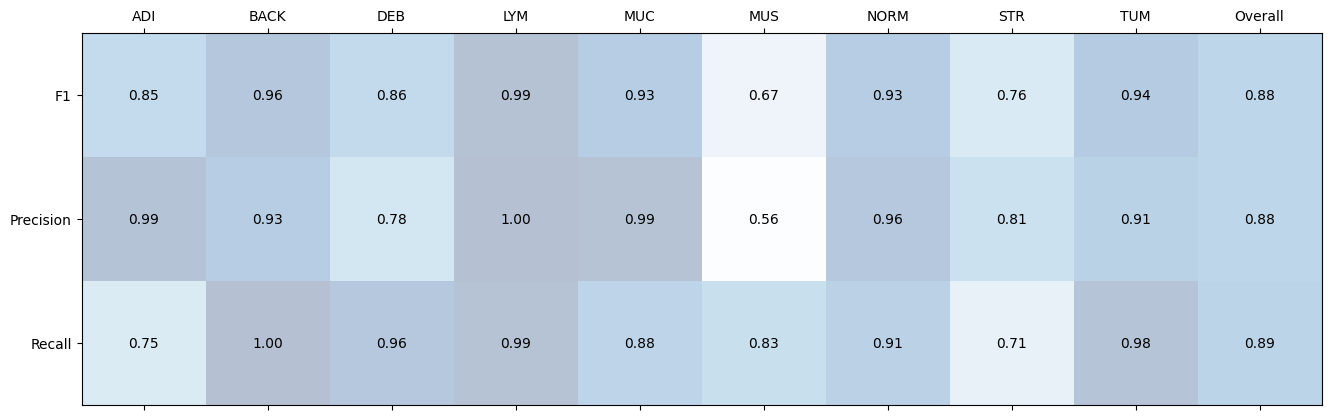

In [86]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )